In [15]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
import torch.nn as nn
import random
import copy
import ipdb


# Parameters:
ANCHORS = torch.tensor([[3.9, 1.6, 1.56, -1, 0], # Anchors as tensor: (height, width, height, z_center, orientation)
                       [3.9, 1.6, 1.56, -1, 1.5708],
                       [0.8, 0.6, 1.73, -0.6, 0],
                       [0.8, 0.6, 1.73, -0.6, 1.5708]]
                       )

# Neural Network Parameters:
AUG_DIM = 9
MAX_POINTS_PER_PILLAR = 100
MAX_FILLED_PILLARS = 12000
X_MIN = 0.0
X_MAX = 70.4
Y_MIN = -40.0
Y_MAX = 40.0
Z_MIN = -3.0
Z_MAX = 1.0
PILLAR_SIZE = (0.16, 0.16)
RADIUS_MARGIN = 20.0 # In feature map



In [16]:
# Map anchors to image:
def map_to_img(value: float, pillar_size: tuple, min_value: float):
    mapped_value = (value - min_value) // pillar_size[0] # Floored division
    assert mapped_value >= 0.0
    return mapped_value

mapped_anchors = ANCHORS.detach().clone()

for anchor in mapped_anchors: # Overrides anchors height, width with mapped length and width
  anchor[0] = map_to_img(value=anchor[0], pillar_size=PILLAR_SIZE, min_value=0.0) # 0.0 as min_value since length is already a delta
  anchor[1] = map_to_img(value=anchor[1], pillar_size=PILLAR_SIZE, min_value=0.0) # 0.0 as min_value since width is already a delta

Create the random image for the test of the algorithm:

In [17]:
# Define the dimensions of the image
H = 500  # Height
W = 440  # Width

# Generate a random tensor of shape (H*W, 3) for a color image (3 channels)
random_tensor = torch.randn(H * W, 3)

# Reshape the tensor to match the image dimensions (H, W, C)
random_image = random_tensor.reshape(H, W, 3)

# Ensure the values are in the [0, 1] range (assuming you want a [0, 1] normalized image)
random_image = (random_image - random_image.min()) / (random_image.max() - random_image.min())
random_image = random_image.permute(2, 0, 1)
batched_random_image = random_image.unsqueeze(0) # Add batch size dim

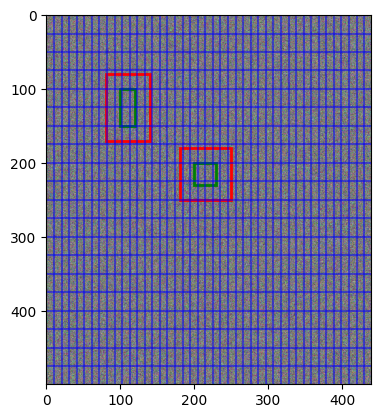

In [26]:
# Create 2D bounding box Class:
class Box2D():
    def __init__(self, x_lims: tuple, y_lims: tuple, x_anchor: float, y_anchor: float, height: float, width: float):
        super().__init__()    
        self.x_anchor = x_anchor
        self.y_anchor = y_anchor
        self.height = height
        self.width = width
        self.x_lims = x_lims
        self.y_lims = y_lims


    def create_marker(self, color='r'):
        return(patches.Rectangle((self.x_anchor, self.y_anchor), width=self.width, 
                height=self.height, linewidth=2, edgecolor=color, facecolor='none'))
    

    def create_ROI(self, margin):
      ROI_box = copy.copy(self)
      ROI_box.x_anchor = self.x_anchor - margin
      ROI_box.y_anchor = self.y_anchor - margin
      ROI_box.height = self.height + 2*margin
      ROI_box.width = self.width + 2*margin

      # Clamp if ROI is out of the feature_map before returning:
      if (ROI_box.x_anchor < self.x_lims[0]): 
        ROI_box.x_anchor = self.x_lims[0]
      elif (ROI_box.x_anchor + ROI_box.width > self.x_lims[1]):
        ROI_box.x_anchor = self.x_lims[1]
      
      if (ROI_box.y_anchor < self.y_lims[0]):
        ROI_box.y_anchor = self.y_lims[0]
      elif (ROI_box.y_anchor + ROI_box.height > self.y_lims[1]):
        ROI_box.y_anchor = self.y_lims[1]

      return ROI_box

# Create a figure and axis for displaying the image
fig, ax = plt.subplots() 


# Create ground truth bounding box coordinates and add rectangles to the image
gt_boxes = [Box2D(x_lims=(0, W), y_lims=(0, H), x_anchor=100, y_anchor=100, height=50, width=20), 
  Box2D(x_lims=(0, W), y_lims=(0, H), x_anchor=200, y_anchor=200, height=30, width=30)]
markers = []

for box in gt_boxes:
  ax.add_patch(box.create_marker(color='g'))
  roi_box = box.create_ROI(margin=RADIUS_MARGIN)
  ax.add_patch(roi_box.create_marker())
  


# Create grid based on anchors:
num_anchors_x = int(torch.round(batched_random_image.size()[-1] / mapped_anchors[0][1])) # Taking width as x
num_anchors_y = int(torch.round(batched_random_image.size()[-2] / mapped_anchors[0][0])) # Taking height as y

# Create a linspace given the anchor size and grid based on the x-y linspaces:
grid_x = torch.linspace(0, batched_random_image.size()[-1], num_anchors_x) # From width to account for 0
grid_y = torch.linspace(0, batched_random_image.size()[-2], num_anchors_y) # From length to account for 0

for x in grid_x:
    ax.axvline(x=x, color='b', alpha=0.5)

for y in grid_y:
    ax.axhline(y=y, color='b', alpha=0.5)


# Display the image using imshow
ax.imshow(batched_random_image[0].permute(1, 2, 0)) # Plot batched_image here